# Objectives

This examples example demonstrates a complete reentry analysis workflow using Tudat's propagation framework. It uses Kosmos 482 reentry as a test case. Kosmos 482 was an attempted Soviet Venus probe launched on 31 March 1972 that became one of the most significant space debris reentry cases in recent history. A problem with its rocket stranded the spacecraft in an elliptical orbit around Earth instead of allowing it to continue to Venus. It reentered Earth Atmosphere on May 10th, 2025. 

Kosmos 482 is exemplary because allows to showcase:
- Long-term orbital decay modeling over 53 years
- Multiple perturbation effects (atmospheric drag, solar radiation pressure, gravitational perturbations)
- Retrieving TLE data from [Space-Track.org](https://www.space-track.org/auth/login) via Tudatpy's **SpaceTrack query**. 
- Validation opportunity since the actual reentry occurred in May 2025

# Import Statements
At the beginning of our example, we import all necessary modules.

In [1]:
from datetime import datetime, timedelta
import math
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.collections import LineCollection
import numpy as np
from tudatpy.interface import spice
from tudatpy.dynamics import environment_setup, environment, propagation_setup, propagation, simulator
from tudatpy.astro import time_representation
from tudatpy.util import result2array
from tudatpy.astro.time_representation import DateTime
from tudatpy.data.spacetrack import SpaceTrackQuery

# Load Spice Kernels
Tudat's default spice kernels are loaded

In [2]:
# Load spice kernels
spice.load_standard_kernels()

In [3]:
# Create time scale converter object
time_scale_converter = time_representation.default_time_scale_converter( )

In [4]:
# Object ID
objname = "KOSMOS 482 DESCENT CRAFT"
catnr = "6073"
cospar = "1972-023E"

norad_id = str(6073)

# Initialize SpaceTrackQuery
SpaceTrackQuery = SpaceTrackQuery()

space-track username:  l.gisolfi@tudelft.nl
space-track password:  ········


In [5]:
# OMM Dict
json_dict = SpaceTrackQuery.DownloadTle.single_norad_id(SpaceTrackQuery, norad_id)

tle_dict = SpaceTrackQuery.OMMUtils.get_tles(SpaceTrackQuery,json_dict)
tle_line1, tle_line2 = tle_dict[norad_id][0], tle_dict[norad_id][1]
tle_reference_epoch = SpaceTrackQuery.OMMUtils.get_tle_reference_epoch(SpaceTrackQuery,tle_line1)

print(f'TLE: \n {tle_line1} \n {tle_line2}')
print(f'TLE Reference Epoch: \n {tle_reference_epoch}')

#---------------------------------------------------------------------------------------------------------------#
# TLE (if you do not possess an account to Space-Track.org)
# tle_line1 = "1  6073U 72023E   25130.02495443  .08088373  12542-4  65849-4 0  9993"  # TLE line 1
# tle_line2 = "2  6073  51.9455 241.9030 0035390 103.6551  63.6433 16.48653575751319"  # TLE line 2
#---------------------------------------------------------------------------------------------------------------#

TLE: 
 1  6073U 72023E   25130.02495443  .08088373  12542-4  65849-4 0  9993 
 2  6073  51.9455 241.9030 0035390 103.6551  63.6433 16.48653575751319
TLE Reference Epoch: 
 2025-05-10 00:35:56.062752


In [6]:
# object mass
mass = 480 # kg
# DRAG AND SRP AREA, DRAG COEFFICIENT
reference_area_drag = 0.7854 # Average projection area of the spacecraft in m^2
reference_area_radiation = 0.7854  # Average projection area of object for SRP. keep 0.0 to ignore SRP
drag_coefficient = 2.2 # drag coefficient
# CUT-OFF ALTITUDE FOR SIMULATION
altitude_limit = 50.0e3  #meters  (standard 50 km = 50.0e3)
# SET SIMULATION START EPOCH
# THIS SHOULD EQUAL THE TIME OF THE TLE EPOCH - NOTE: no leading zeros, format yyyy, m, d, h, m, s.sss
simulation_start_utc = tle_reference_epoch
# SET  SIMULATION END EPOCH (cuts off run if altitude criterion not met before)
simulation_end_utc = tle_reference_epoch + timedelta(seconds = 86400*365) # one hour after observation start

float_observations_start_utc = time_representation.DateTime.from_python_datetime(simulation_start_utc).to_epoch()
float_observations_end_utc = time_representation.DateTime.from_python_datetime(simulation_end_utc).to_epoch()

SET OPTION FULL OUTPUT OR ONLY END RESULT? ('full', 'selected',"J2K",'endonly')

In [7]:
outopt = 'full'

    # full = selected data, J2K States and end result out
    # selected = only selected data and end result out
    # J2K = only State and end result out
    # endonly = only end result out
# SET OPTIONAL OUTPUT FILE NAME SUFFIX
filenamesuf = "_KMOS482_480kg_FINAL"
# SET OPTION FOR SAVE INTERVAL IF DESIRED TO NOT SAVE EACH STEP (yes/no?)
interval_set = 'no'
interval = 20  #seconds   10 days = 864000 seconds 1 day = 86400 seconds 1 hr = 3600 seconds

In [8]:
# start and end epoch of simulation conversion from UTC to tdb
simulation_start_epoch_tdb = time_scale_converter.convert_time(
  input_scale = time_representation.utc_scale,
  output_scale = time_representation.tdb_scale,
  input_value = float_observations_start_utc)
simulation_end_epoch_tdb = time_scale_converter.convert_time(
  input_scale = time_representation.utc_scale,
  output_scale = time_representation.tdb_scale,
  input_value = float_observations_end_utc)

In [9]:
# some values to strings for output later
mass_string = str(mass)
area_string = str(reference_area_drag)
altitude_limit_string = str(altitude_limit)

In [10]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon"]

In [11]:
# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

In [12]:
# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

In [13]:
# Create Earth rotation model
body_settings.get("Earth").rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
                environment_setup.rotation_model.iau_2006,
                global_frame_orientation )
body_settings.get("Earth").gravity_field_settings.associated_reference_frame = "ITRS"

In [14]:
# create atmosphere settings and add to body settings of body "Earth"
body_settings.get( "Earth" ).atmosphere_settings = environment_setup.atmosphere.nrlmsise00()

In [15]:
# Create earth shape model
body_settings.get("Earth").shape_settings = environment_setup.shape.oblate_spherical( 6378137.0, 1.0 / 298.257223563)

In [16]:
# Create empty body settings for the satellite, generic name 'candidate'
body_settings.add_empty_settings("candidate")

In [17]:
# Create aerodynamic coefficient interface settings
# reference_area_drag already defined earlier!
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area_drag, [drag_coefficient, 0.0, 0.0]
)

In [18]:
# Add the aerodynamic interface to the body settings
body_settings.get("candidate").aerodynamic_coefficient_settings = aero_coefficient_settings

In [19]:
# Create radiation pressure settings
# reference_area_radiation already defined earlier!
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]
vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict )

In [20]:
# Add the radiation pressure interface to the body settings
body_settings.get("candidate").radiation_pressure_target_settings = vehicle_target_settings

In [21]:
# Add body mass
bodies = environment_setup.create_system_of_bodies(body_settings)
bodies.get("candidate").mass = mass  #mass in kg, already set earlier!

In [22]:
# Define bodies that are propagated
bodies_to_propagate = ["candidate"]

In [23]:
# Define central bodies of propagation
central_bodies = ["Earth"]

In [24]:
# Define accelerations acting on reentry candidate by Sun and Earth.
accelerations_settings_candidate = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

In [25]:
# Create global accelerations settings dictionary.
acceleration_settings = {"candidate": accelerations_settings_candidate}

In [26]:
# Create the acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

In [27]:
# Retrieve the initial state of the reentry candidate using Two-Line-Elements (TLEs)
candidate_tle = environment.Tle(
  tle_line1, tle_line2
)
candidate_ephemeris = environment.TleEphemeris( "Earth", "J2000", candidate_tle, False )
initial_state = candidate_ephemeris.cartesian_state( simulation_start_epoch_tdb )

In [28]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.altitude("candidate", "Earth"),
    propagation_setup.dependent_variable.geodetic_latitude("candidate", "Earth"),
    propagation_setup.dependent_variable.longitude("candidate", "Earth"),
    propagation_setup.dependent_variable.periapsis_altitude("candidate", "Earth"),
    propagation_setup.dependent_variable.apoapsis_altitude("candidate", "Earth"),
    propagation_setup.dependent_variable.body_fixed_groundspeed_velocity("candidate", "Earth")
]

In [29]:
# Define a termination condition to stop once altitude goes below a certain value (defined earlier!)
termination_altitude_settings = propagation_setup.propagator.dependent_variable_termination(
    dependent_variable_settings=propagation_setup.dependent_variable.altitude("candidate", "Earth"),
    limit_value=altitude_limit,
    use_as_lower_limit=True)
# Define a termination condition to stop after a given time (to avoid an endless skipping re-entry)
termination_time_settings = propagation_setup.propagator.time_termination(simulation_end_epoch_tdb)
# Combine the termination settings to stop when one of them is fulfilled
combined_termination_settings = propagation_setup.propagator.hybrid_termination(
    [termination_altitude_settings, termination_time_settings], fulfill_single_condition=True )

In [30]:
# Create numerical integrator settings
# Create RK settings / RK7(8)
control_settings = propagation_setup.integrator.step_size_control_elementwise_scalar_tolerance( 1.0E-10, 1.0E-10 )
validation_settings = propagation_setup.integrator.step_size_validation( 0.001, 2700.0 )
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step(
    initial_time_step = 60.0,
    coefficient_set = propagation_setup.integrator.rkf_78,
    step_size_control_settings = control_settings,
    step_size_validation_settings = validation_settings )

In [31]:
# Create the propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch_tdb,
    integrator_settings,
    combined_termination_settings,
    output_variables=dependent_variables_to_save
)

In [32]:
# Set output data save interval if defined
if interval_set == 'yes':
    propagator_settings.processing_settings.results_save_frequency_in_seconds = interval
    propagator_settings.processing_settings.results_save_frequency_in_steps = 0

In [33]:
# Create the simulation objects and propagate the dynamics
dynamics_simulator = simulator.create_dynamics_simulator(
    bodies, propagator_settings
)

In [34]:
# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)

In [35]:
# Extract the resulting simulation dependent variables
dependent_variables = dynamics_simulator.propagation_results.dependent_variable_history
# Convert the dependent variables from a dictionary to a numpy array
dependent_variables_array = result2array(dependent_variables)

WRITE RESULTS TO SCREEN AND TO TEXT FILES

In [36]:
data = dependent_variables_array
length = len(data)
lastline= (data[length-1])

In [37]:
print(' ')
print('mass: ' + mass_string + ' kg')
print('drag area: ' + area_string +' m^2')
print('altitude limit: ' + altitude_limit_string  +' meter')
print(' ')

 
mass: 480 kg
drag area: 0.7854 m^2
altitude limit: 50000.0 meter
 


In [38]:
# parse reentry date and position in human-readable format
# time and position
eindtijd = lastline[0]
altid = (lastline[1])/1000.0
lat = math.degrees(lastline[2])
lon = math.degrees(lastline[3])
latstring =  "{:.2f}".format(lat)
lonstring = "{:.2f}".format(lon)
altstring = "{:.3f}".format(altid)
# integration window duration to reentry
duur = eindtijd - simulation_start_epoch_tdb
uren = (duur/3600.0)
urenstring = "{:.3f}".format(uren)
dagen = uren/24.0
dagenstring = "{:.3f}".format(dagen)

In [39]:
# reentry time
import datetime
date_1 = datetime.datetime(2000,1,1,12,0,0)
eindtijd = eindtijd - 64.184  # tdb to UTC
eindtijd_uren = (eindtijd/3600.0)
eindtijd_dagen = eindtijd_uren/24.0
end_date = date_1 + datetime.timedelta(days=eindtijd_dagen)
reentrydatestring = str(end_date)
propstart = date_1 + datetime.timedelta(days=((float_observations_start_utc/3600.0)/24.0))
propstartstring = str(propstart)
propstartstring = propstartstring + " UTC"
propendstring = str(end_date)
propendstring = propendstring + " UTC"

In [40]:
# get uncertainty estimate (25% of integration window duration)
sigm = 0.25 * uren    # sigma defined as 25% of time between TLE epoch and reentry
if sigm < 26.0:
    formatted_number = "%.2f" % sigm
    sigm_string = str(formatted_number)
    sigm_string = sigm_string + ' hr'
if sigm < 1.0:
    sigm_mins = 0.25 *(duur/60.0)
    formatted_number = "%.2f" % sigm_mins
    sigm_string = str(formatted_number)
    sigm_string = sigm_string + ' min'
if sigm >= 26.0:
    sigm_days = 0.25 * dagen
    formatted_number = "%.2f" % sigm_days
    sigm_string = str(formatted_number)
    sigm_string = sigm_string + ' days'

In [41]:
# print data to screen
print(' ')
print('propagation start:  ' + propstartstring)
print('propagation end:    ' + propendstring)
print(" ")

 
propagation start:  2025-05-10 00:35:56.062752 UTC
propagation end:    2025-05-10 06:42:00.897397 UTC
 


In [42]:
if (altid * 1e3) > altitude_limit:
    print("OBJECT DID NOT REENTER WITHIN DEFINED TIMESPAN...")
else:
    print('final altitude ' + altstring + ' km')
    print(" ")
    print('reentry after ' + urenstring + ' hours  = ' + dagenstring + ' days')
    print(" ")
    print ('REENTRY AT:')
    print(reentrydatestring + ' UTC  +-  ' + sigm_string)
    print('lat: ' + latstring + '   lon: ' + lonstring)
print(" ")
print(" ")

final altitude 49.945 km
 
reentry after 6.100 hours  = 0.254 days
 
REENTRY AT:
2025-05-10 06:42:00.897397 UTC  +-  1.52 hr
lat: -43.22   lon: 138.78
 
 


SAVE THE OUTPUT TO TEXT FILE(S)

In [43]:
from numpy import savetxt

In [44]:
# Save intermediate data to a comma-delimited txt file if option was chosen earlier
if outopt == 'selected':
    savetxt('variables_out' + filenamesuf + '.txt', dependent_variables_array, delimiter=',')
    savetxt('J2Kstate_out' + filenamesuf + '.txt', states_array, delimiter=',')

In [45]:
if outopt == 'selected':
    savetxt('variables_out' + filenamesuf + '.txt', dependent_variables_array, delimiter=',')

In [46]:
if outopt == 'J2K':
    savetxt('J2Kstate_out' + filenamesuf + '.txt', states_array, delimiter=',')

In [47]:
# Save final data (reentry date and position) to a text file
savetxt('reentrytime_out' + filenamesuf + '.txt', lastline, delimiter=',')

In [48]:
# Re-open the file in append mode and append
file = open('reentrytime_out' + filenamesuf + '.txt', 'a')

In [49]:
#Append reentry info to the file
file.write('\n')
file.write('\n' + 'OBJECT: ' + objname + '\n')
file.write('CATNR:  ' + catnr + '\n')
file.write('COSPAR: ' + cospar + '\n')
file.write('\n')
file.write(tle_line1 + '\n')
file.write(tle_line2 + '\n')
file.write('\n')
file.write('mass: ' + mass_string + ' kg\n')
file.write('drag area: ' + area_string +' m^2\n')
file.write('altitude limit: ' + altitude_limit_string  +' meter\n' + '\n')
file.write('propagation start: ' + propstartstring + '\n')
file.write('propagation end:   ' + propendstring + '\n')
file.write('final altitude:    ' + altstring + '\n')
file.write('\n')
if (altid * 1e3) > altitude_limit:
    file.write('OBJECT DID NOT REENTER IN THIS TIMESPAN\n')
else:
    file.write('reentry after ' + dagenstring + ' days\n')
    file.write('\n')
    file.write('REENTRY AT:\n')
    file.write( reentrydatestring + ' UTC  +-  ' + sigm_string+'\n')
    file.write('lat: ' + latstring + '\n')
    file.write('lon: ' + lonstring + '\n')

In [50]:
# Close the file
file.close()
print("output data have been written to files in home directory")
print(" ")

output data have been written to files in home directory
 


In [51]:
# Load cities data
cities = gpd.read_file("ne_10m_populated_places.shp")
big_cities = cities[cities['POP_MAX'] > 1e6]

In [52]:
# Ground track data
latitudes = np.degrees(dependent_variables_array[:, 2])
longitudes = (np.degrees(dependent_variables_array[:, 3]) + 180) % 360 - 180
times = dependent_variables_array[:, 0]

In [53]:
times_since = (np.array(times) - times[0])/3600

In [54]:
utc_times = [time_representation.DateTime.to_python_datetime(time_representation.DateTime.from_epoch(time)) for time in times]

In [55]:
# Line segments for colored path
points = np.array([longitudes, latitudes]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(times_since.min(), times_since.max())
lc = LineCollection(segments, cmap='Purples', norm=norm, linewidth=2, transform=ccrs.Geodetic())
lc.set_array(times_since)

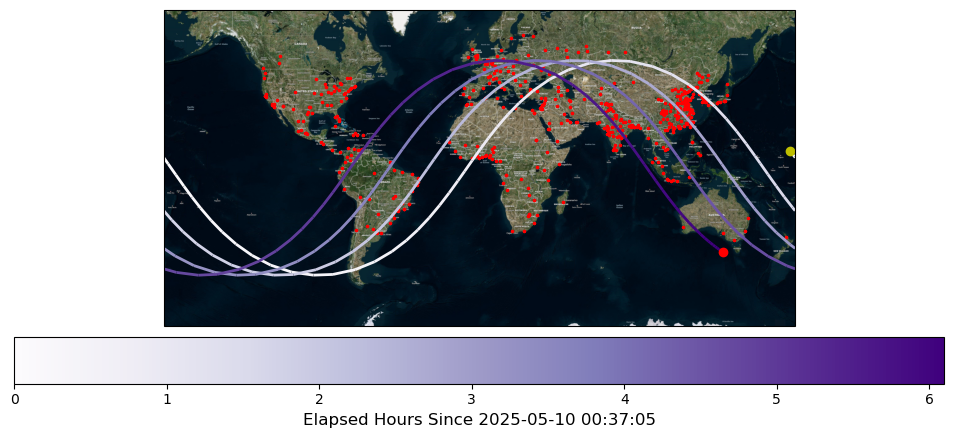

In [56]:

# Satellite imagery tiler
tiler = cimgt.QuadtreeTiles()  # Good for testing
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=tiler.crs)
#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.add_image(tiler, 4)
# Add colored ground track
ax.add_collection(lc)
cbar = plt.colorbar(lc, ax=ax, orientation='horizontal', pad=0.03)
cbar.set_label(f"Elapsed Hours Since {utc_times[0].strftime('%Y-%m-%d %H:%M:%S')}", fontsize=12)
# Start/End markers
ax.plot(longitudes[0], latitudes[0], 'yo', markersize=6, transform=ccrs.PlateCarree(), label='Start')
ax.plot(longitudes[-1], latitudes[-1], 'ro', markersize=6, transform=ccrs.PlateCarree(), label=f"Reentry ({reentrydatestring[:16]} UTC +- {sigm_string})")
# Add cities > 1M population
ax.scatter(
    big_cities.geometry.x,
    big_cities.geometry.y,
    color='red',
    s=2,
    transform=ccrs.PlateCarree(),
    label='Cities > 1M'
)
# Add cities > 1M population
ax.scatter(
    big_cities.geometry.x,
    big_cities.geometry.y,
    color='red',
    s=2,
    transform=ccrs.PlateCarree(),
    label='Cities > 1M'
)